# Inference notebook 

- I have used deit_tiny model that was trained on our team dataset

In [7]:
# === Cell 1 : Imports + Setup ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from math import sqrt


# === CONFIG ===
MODEL_NAME = "deit_tiny_patch16_224"
MODEL_PATH = "./models/deit_tiny_patch16_224_best.pth"
LABELS_CSV = "./labels.csv"   # file that contains canonical class labels
IMAGE_DIR  = r"D:\multi-class-image-classifier\data\images"
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE   = 96
TOP_K      = 3

print(f"✅ Using device: {DEVICE}")


✅ Using device: cuda


In [8]:
# === Cell 2 : Load Canonical Class Names from labels.csv ===
# (Assumes 'class_label' column exists as in your labels.csv)

labels_df = pd.read_csv(r'D:\multi-class-image-classifier\labels.csv')
classes = sorted(labels_df['class_label'].unique())
print(f"✅ Canonical classes loaded ({len(classes)}): {classes}")


✅ Canonical classes loaded (10): ['Cup', 'calculator', 'cap', 'earphones', 'keyboard', 'mouse', 'scissor', 'sneakers', 'umbrella', 'wristwatch']


In [9]:
# === Cell 3 : Load the trained 96×96 ViT ===
def load_vit_inference(model_name, checkpoint_path, num_classes, device, img_size=96):
    """
    Loads a ViT trained on 96×96 images and adjusts positional embeddings accordingly.
    """
    state = torch.load(checkpoint_path, map_location="cpu")
    if isinstance(state, dict):
        if "model" in state:
            state = state["model"]
        elif "state_dict" in state:
            state = state["state_dict"]

    pos_key = next(k for k in state.keys() if "pos_embed" in k)
    ck_pos = state[pos_key]
    dim = ck_pos.shape[-1]

    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    model.patch_embed.img_size = (img_size, img_size)
    model.patch_embed.num_patches = (img_size // 16) ** 2
    model.pos_embed = nn.Parameter(torch.zeros(1, model.patch_embed.num_patches + 1, dim))

    missing, unexpected = model.load_state_dict(state, strict=False)
    print(f"Loaded checkpoint → missing:{len(missing)}  unexpected:{len(unexpected)}")
    return model.to(device).eval()

model = load_vit_inference(MODEL_NAME, MODEL_PATH, len(classes), DEVICE, img_size=IMG_SIZE)


Loaded checkpoint → missing:0  unexpected:0


In [10]:
# === Cell 4 : Pre-processing & Inference Utilities (with image display) ===
from torchvision import transforms
import matplotlib.pyplot as plt

preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

def load_image(img_path):
    img = Image.open(img_path).convert("RGB")
    return preprocess(img).unsqueeze(0)

def predict_image(img_path, top_k=TOP_K, show=True):
    """
    Predict top-k classes for an image and optionally display it.
    """
    img_tensor = load_image(img_path).to(DEVICE)
    with torch.no_grad():
        logits = model(img_tensor)
        probs = F.softmax(logits, dim=1).cpu().numpy().flatten()
    topk_idx = probs.argsort()[-top_k:][::-1]

    print(f"\n🔍 Results for: {os.path.basename(img_path)}")
    for rank, idx in enumerate(topk_idx, 1):
        print(f"  {rank}. {classes[idx]:<12s} — {probs[idx]*100:6.2f}%")

    # --- show image at the end ---
    if show:
        img = Image.open(img_path).convert("RGB")
        plt.figure(figsize=(3,3))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Top-1: {classes[topk_idx[0]]} ({probs[topk_idx[0]]*100:.1f}%)")
        plt.show()



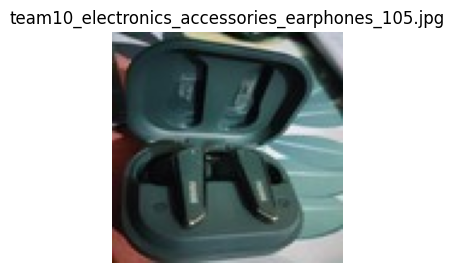


🔍 Results for: team10_electronics_accessories_earphones_105.jpg
  1. earphones    —  94.82%
  2. umbrella     —   3.57%
  3. Cup          —   0.57%


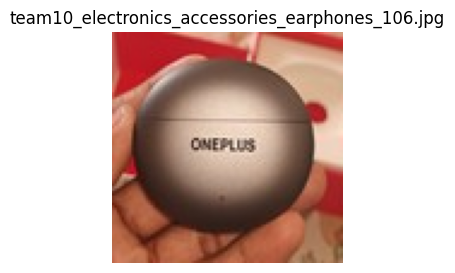


🔍 Results for: team10_electronics_accessories_earphones_106.jpg
  1. earphones    —  97.91%
  2. mouse        —   0.69%
  3. umbrella     —   0.41%



🔍 Results for: team10_electronics_accessories_earphones_107.jpg
  1. earphones    —  98.84%
  2. wristwatch   —   0.31%
  3. umbrella     —   0.18%


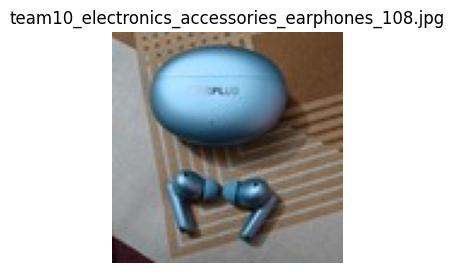


🔍 Results for: team10_electronics_accessories_earphones_108.jpg
  1. earphones    —  76.19%
  2. Cup          —  11.81%
  3. mouse        —   9.26%



🔍 Results for: team10_electronics_accessories_earphones_109.jpg
  1. earphones    —  66.22%
  2. mouse        —  10.18%
  3. umbrella     —   7.99%


In [11]:
# === Cell 5 : Run on sample images (and display them) ===
import matplotlib.pyplot as plt
from PIL import Image

sample_images = [
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
][40:45]

for path in sample_images:
    # --- show the image ---
    img = Image.open(path).convert("RGB")
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(os.path.basename(path))
    plt.show()

    # --- then run prediction and print results ---
    predict_image(path, show=False)   # show=False avoids re-plotting inside the function



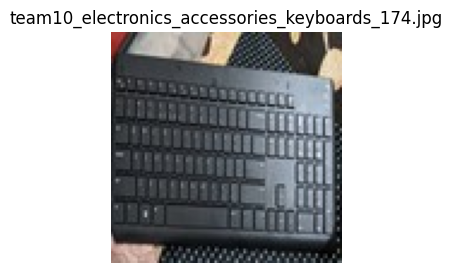


🔍 Results for: team10_electronics_accessories_keyboards_174.jpg
  1. calculator   —  62.74%
  2. keyboard     —  18.22%
  3. umbrella     —   9.00%


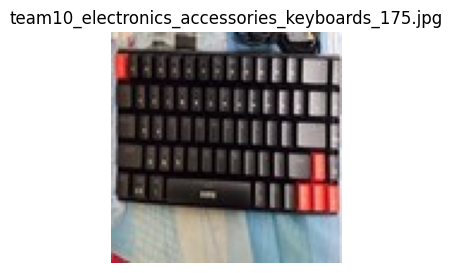


🔍 Results for: team10_electronics_accessories_keyboards_175.jpg
  1. calculator   —  96.14%
  2. umbrella     —   1.47%
  3. keyboard     —   0.71%


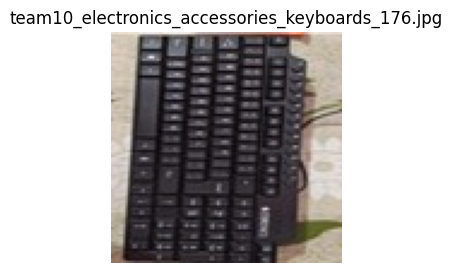


🔍 Results for: team10_electronics_accessories_keyboards_176.jpg
  1. calculator   —  87.08%
  2. keyboard     —   9.63%
  3. umbrella     —   1.68%



🔍 Results for: team10_electronics_accessories_keyboards_177.jpg
  1. keyboard     —  44.05%
  2. calculator   —  42.16%
  3. umbrella     —   8.35%


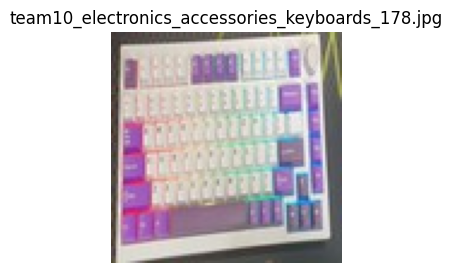


🔍 Results for: team10_electronics_accessories_keyboards_178.jpg
  1. umbrella     —  49.89%
  2. calculator   —  24.61%
  3. Cup          —   9.02%


In [12]:
# === Cell 5 : Run on sample images (and display them) ===
import matplotlib.pyplot as plt
from PIL import Image

sample_images = [
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
][100:105]

for path in sample_images:
    # --- show the image ---
    img = Image.open(path).convert("RGB")
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(os.path.basename(path))
    plt.show()

    # --- then run prediction and print results ---
    predict_image(path, show=False)   # show=False avoids re-plotting inside the function



## Text to image Retreival

In [14]:
# === Cell 6: Text-to-Image Retrieval using trained ViT ===
import heapq
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
IMAGE_DIR = r"D:\multi-class-image-classifier\data\images"


def image_to_tensor(img_path):
    img = Image.open(img_path).convert("RGB")
    return preprocess(img).unsqueeze(0)

def predict_single(img_tensor):
    with torch.no_grad():
        logits = model(img_tensor.to(DEVICE))
        probs = F.softmax(logits, dim=1).cpu().numpy().flatten()
    return probs

def text_to_image_retrieval(query, image_dir=IMAGE_DIR, top_k=5):
    """
    Retrieve top-k images most relevant to the query (matching class label).
    """
    query = query.strip().lower()
    # simple mapping: find canonical class whose name is closest match
    matched_class = None
    for c in classes:
        if query in c.lower() or c.lower() in query:
            matched_class = c
            break
    if matched_class is None:
        print(f"❌ Query '{query}' did not match any known class.")
        return
    
    print(f"🔍 Searching for images predicted as '{matched_class}' ...")
    class_idx = classes.index(matched_class)

    # evaluate all images in folder
    results = []
    files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    for fname in tqdm(files, desc="Scanning images"):
        path = os.path.join(image_dir, fname)
        img_tensor = image_to_tensor(path)
        probs = predict_single(img_tensor)
        score = probs[class_idx]   # confidence for this class
        results.append((score, path))
    
    # top-k images by score
    top_results = heapq.nlargest(top_k, results, key=lambda x: x[0])
    
    # --- show results ---
    plt.figure(figsize=(3*top_k, 3))
    for i, (score, path) in enumerate(top_results):
        img = Image.open(path).convert("RGB")
        plt.subplot(1, top_k, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{os.path.basename(path)}\n{score*100:.1f}%")
    plt.suptitle(f"Top {top_k} matches for query: '{query}' (class '{matched_class}')")
    plt.tight_layout()
    plt.show()



🔍 Searching for images predicted as 'calculator' ...


Scanning images:   0%|          | 0/11894 [00:00<?, ?it/s]

Scanning images: 100%|██████████| 11894/11894 [01:24<00:00, 140.78it/s]


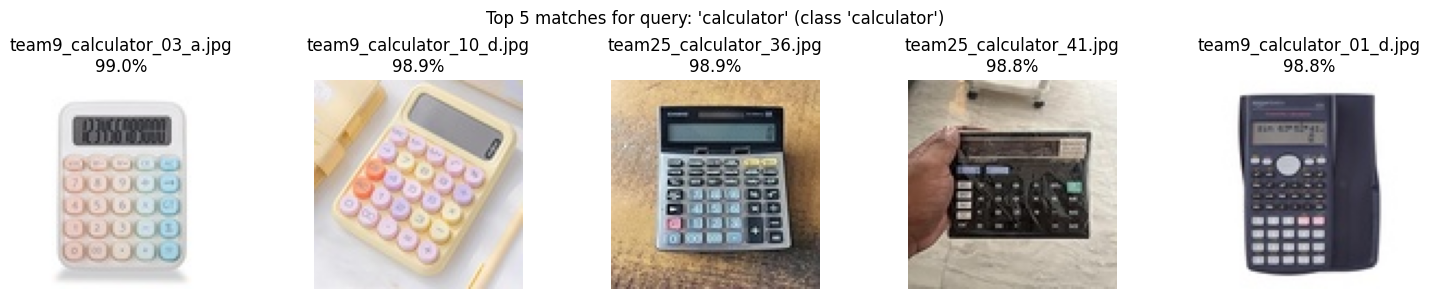

🔍 Searching for images predicted as 'cap' ...


Scanning images: 100%|██████████| 11894/11894 [01:22<00:00, 144.27it/s]


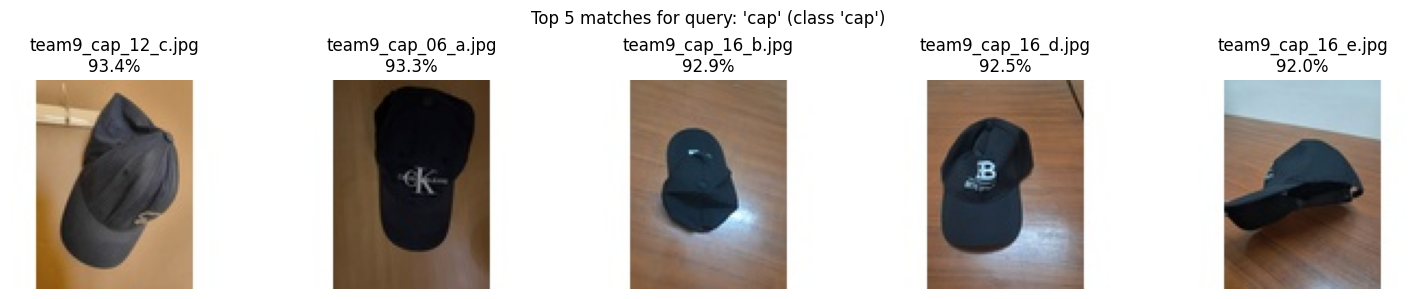

🔍 Searching for images predicted as 'Cup' ...


Scanning images: 100%|██████████| 11894/11894 [01:22<00:00, 144.59it/s]


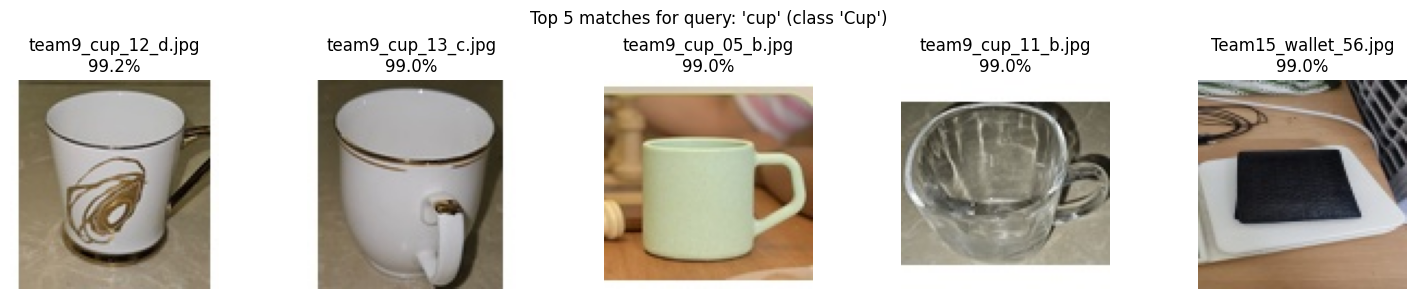

🔍 Searching for images predicted as 'earphones' ...


Scanning images: 100%|██████████| 11894/11894 [01:23<00:00, 142.89it/s]


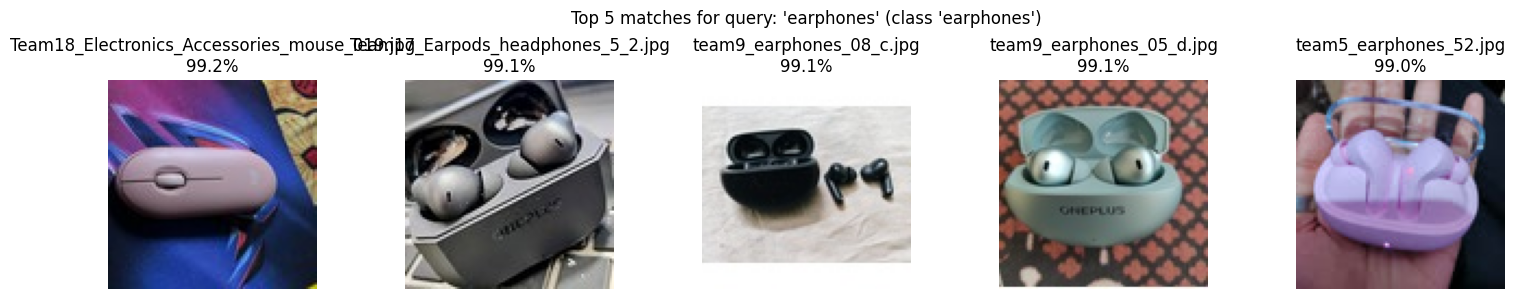

🔍 Searching for images predicted as 'keyboard' ...


Scanning images: 100%|██████████| 11894/11894 [01:22<00:00, 144.05it/s]


🔍 Searching for images predicted as 'mouse' ...


Scanning images: 100%|██████████| 11894/11894 [01:22<00:00, 144.99it/s]


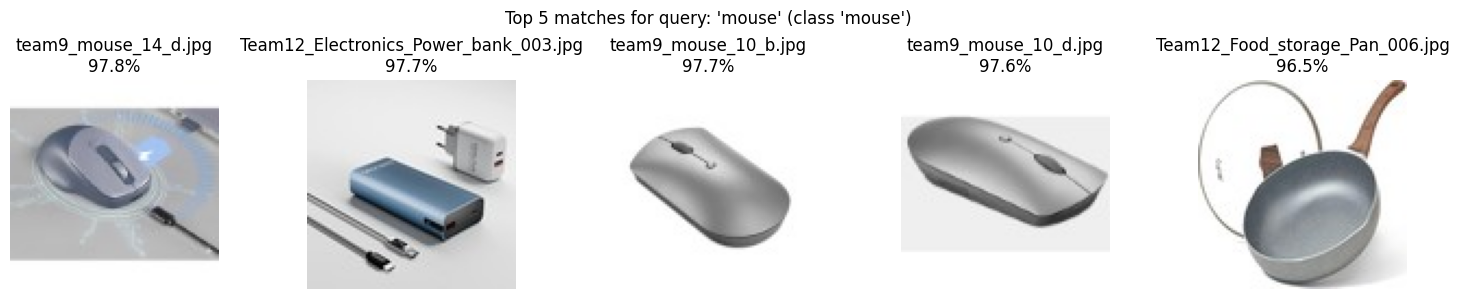

🔍 Searching for images predicted as 'scissor' ...


Scanning images: 100%|██████████| 11894/11894 [01:22<00:00, 143.73it/s]


🔍 Searching for images predicted as 'sneakers' ...


Scanning images: 100%|██████████| 11894/11894 [01:22<00:00, 143.70it/s]


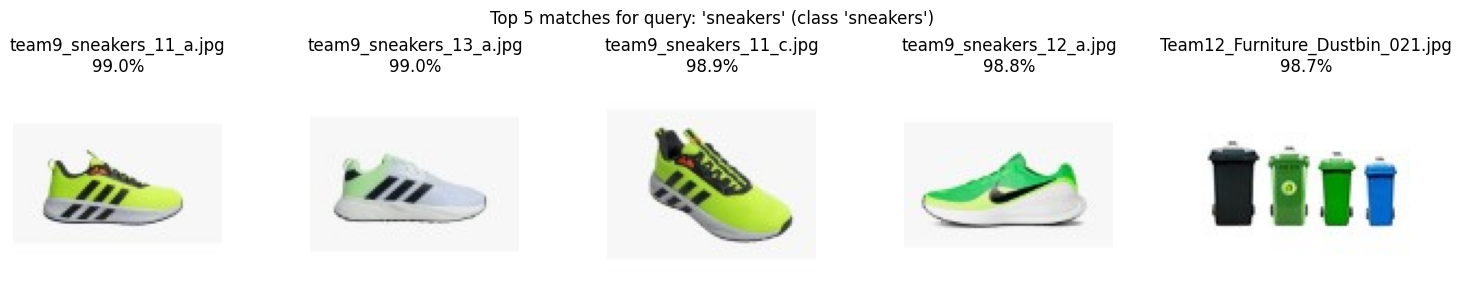

🔍 Searching for images predicted as 'umbrella' ...


Scanning images: 100%|██████████| 11894/11894 [01:22<00:00, 144.36it/s]


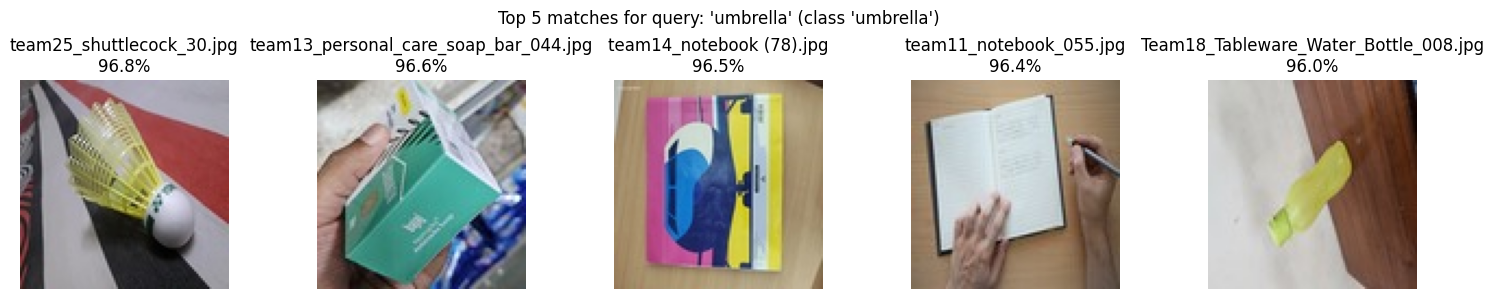

🔍 Searching for images predicted as 'wristwatch' ...


Scanning images: 100%|██████████| 11894/11894 [01:23<00:00, 142.28it/s]


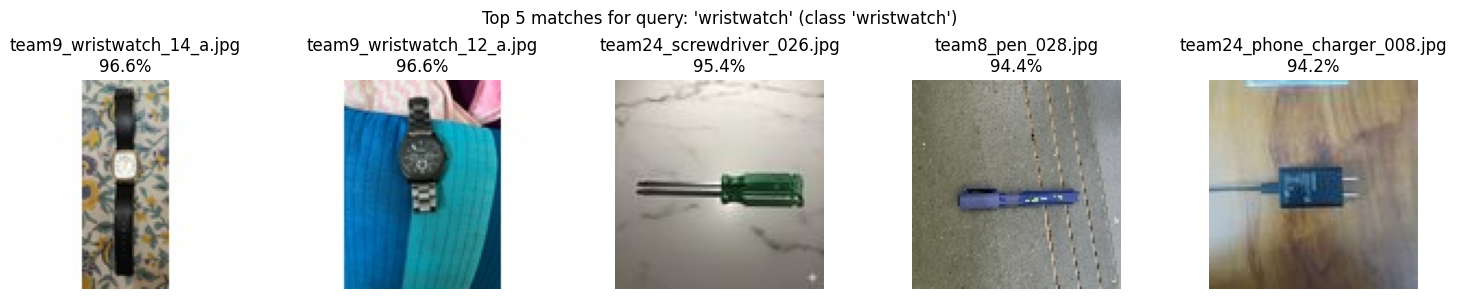

In [16]:
# === Cell 7: Run text-to-image retrieval examples ===

queries = ["calculator",
"cap",
"cup",
"earphones",
"keyboard",
"mouse",
"scissors",
"sneakers",
"umbrella",
"wristwatch"]

for q in queries:
    text_to_image_retrieval(q, IMAGE_DIR, top_k=5)
